In [1]:
from pathlib import Path
from fastai.vision.all import *

Train the model using resnet

In [2]:
dls = ImageDataLoaders.from_folder(
    Path('../data/processed'), 
    train='train', 
    valid_pct=0.2,
    size=224,
    bs=4,
    shuffle_train=True,
    # item_tfms=Resize(256, method=ResizeMethod.Squish)
)

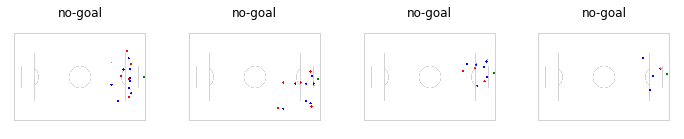

In [3]:
dls.show_batch(nrows=1, ncols=4)

In [4]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.455260,25.771093,0.894949,0.105051,04:37


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.401678,0.300959,0.093939,0.906061,05:52


Review the model

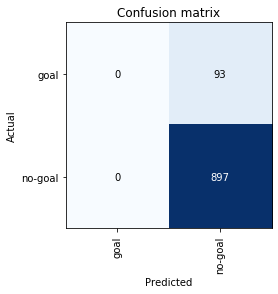

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Make some predictions on the test-data.

First, let's go through predicting a single image...

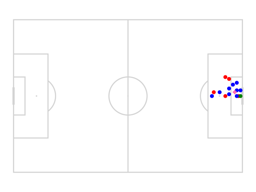

In [6]:
import PIL

# Load an image from the test data
example_img = PILImage.create('../data/processed/test/goal/07d8857c-00fc-4f4d-b1ae-86b1ed377133.png')

display(example_img.to_thumb(256, 256))

In [7]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.14003045856952667


Load all test data

In [8]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [9]:
def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = Path('../data/processed/test/goal/').ls() + Path('../data/processed/test/no-goal/').ls()
shots_predicted = [process_test_shot(s) for s in (test_shots[0:10] + test_shots[-10:])]

In [10]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/test/goal/85525ef9-5c11-4022-b1bb-c99c2b4d5438.png,85525ef9-5c11-4022-b1bb-c99c2b4d5438,True,0.105497,0.608452,0.502956
1,../data/processed/test/goal/ec46fa42-ad15-41c3-a636-98d1f1aef472.png,ec46fa42-ad15-41c3-a636-98d1f1aef472,True,0.122598,0.084931,0.037667
2,../data/processed/test/goal/2bf35d45-298f-4f3b-a1bb-df95b7082500.png,2bf35d45-298f-4f3b-a1bb-df95b7082500,True,0.052165,0.395538,0.343374
3,../data/processed/test/goal/82557ca0-f831-4ed6-9c97-446f511d5b96.png,82557ca0-f831-4ed6-9c97-446f511d5b96,True,0.097481,0.045310,0.052172
4,../data/processed/test/goal/6e60e15e-cdc5-45de-b3c8-9f3fee863f3e.png,6e60e15e-cdc5-45de-b3c8-9f3fee863f3e,True,0.192665,0.136169,0.056496
5,../data/processed/test/goal/95f5ce6d-e6d3-40b7-986c-155cb1ca67fd.png,95f5ce6d-e6d3-40b7-986c-155cb1ca67fd,True,0.150370,0.014144,0.136227
6,../data/processed/test/goal/4033b905-83ae-4fe4-9efe-f88880c04271.png,4033b905-83ae-4fe4-9efe-f88880c04271,True,0.217345,0.208701,0.008644
7,../data/processed/test/goal/f233fa8b-52bc-48d4-8477-2c4a6a2f9006.png,f233fa8b-52bc-48d4-8477-2c4a6a2f9006,True,0.017270,0.142359,0.125089
8,../data/processed/test/goal/4a92a72a-3a81-499e-98d1-fdf065025519.png,4a92a72a-3a81-499e-98d1-fdf065025519,True,0.078312,0.034720,0.043593
9,../data/processed/test/goal/84ab1af4-93c7-479d-ad11-74cdb94813af.png,84ab1af4-93c7-479d-ad11-74cdb94813af,True,0.091876,0.520126,0.428250


Compare to SB xG

Im-xG: 0.11
SB-xG: 0.61
Diff:  0.50


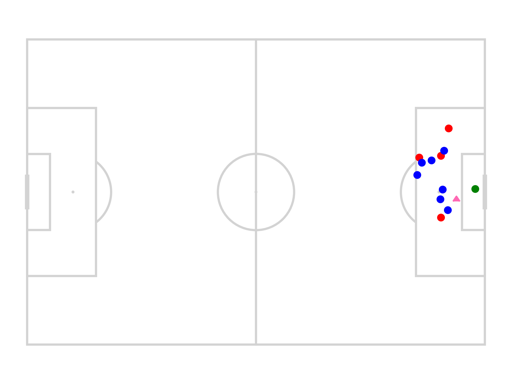

Im-xG: 0.12
SB-xG: 0.08
Diff:  0.04


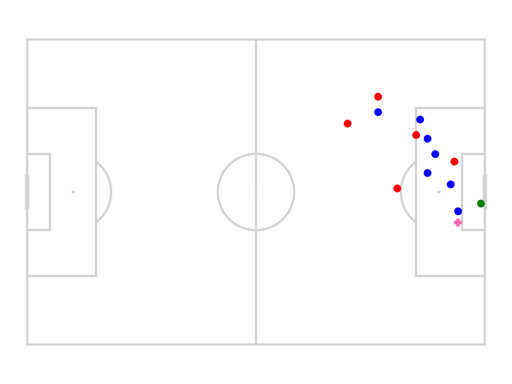

Im-xG: 0.05
SB-xG: 0.40
Diff:  0.34


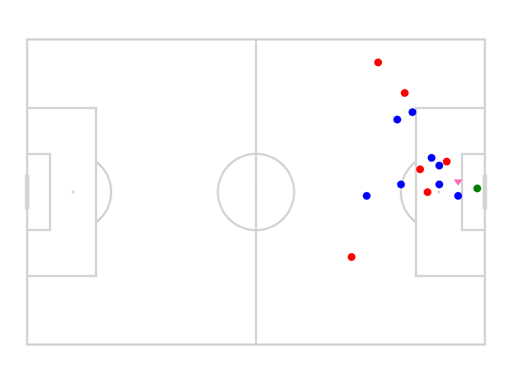

Im-xG: 0.10
SB-xG: 0.05
Diff:  0.05


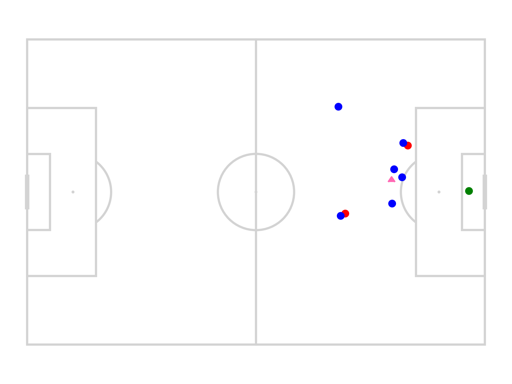

Im-xG: 0.19
SB-xG: 0.14
Diff:  0.06


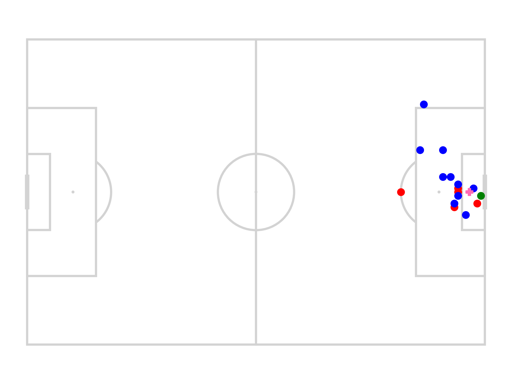

Im-xG: 0.15
SB-xG: 0.01
Diff:  0.14


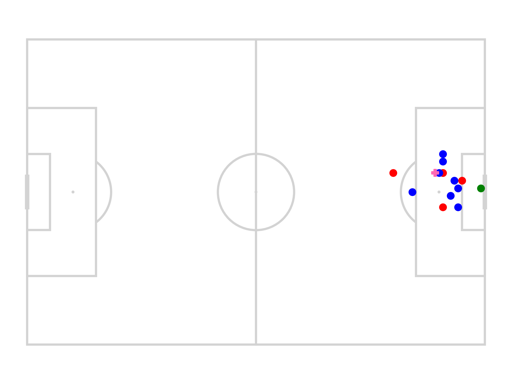

Im-xG: 0.22
SB-xG: 0.21
Diff:  0.01


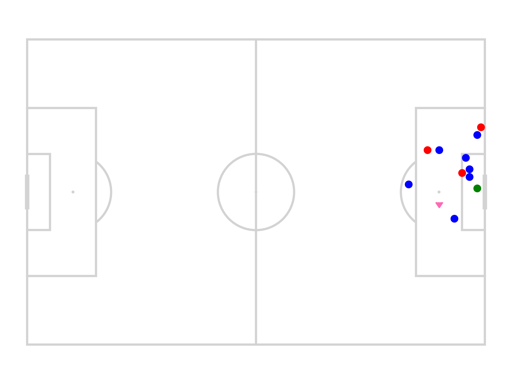

Im-xG: 0.02
SB-xG: 0.14
Diff:  0.13


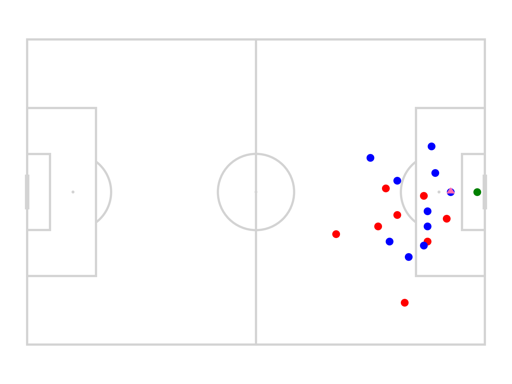

Im-xG: 0.08
SB-xG: 0.03
Diff:  0.04


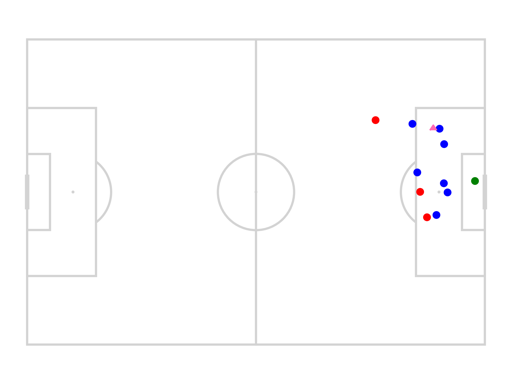

Im-xG: 0.09
SB-xG: 0.52
Diff:  0.43


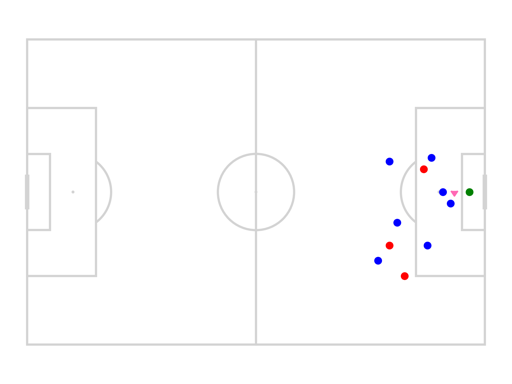

In [11]:
for _, p in predictions.head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

In [12]:
# Compare overall error rate between SB and image xG

In [13]:
# Show the most different N predictions (top & bottom)